## 11-830 HW2: Advanced Analysis
Training neural networks and checking for performance

In [319]:
import numpy as np
np.random.seed(42)
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
plt.style.use('ggplot')

import tensorflow as tf
import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#NLP tools
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [320]:
# from ekphrasis.classes.preprocessor import TextPreProcessor
# from ekphrasis.classes.tokenizer import SocialTokenizer
# from ekphrasis.dicts.emoticons import emoticons

# text_processor = TextPreProcessor(
#     # terms that will be normalized
#     normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
#         'time', 'url', 'date', 'number'],
#     # terms that will be annotated
# #     annotate={"hashtag", "allcaps", "elongated", "repeated",
# #         'emphasis', 'censored'},
#     fix_html=True,  # fix HTML tokens
    
#     # corpus from which the word statistics are going to be used 
#     # for word segmentation 
#     segmenter="twitter", 
    
#     # corpus from which the word statistics are going to be used 
#     # for spell correction
#     corrector="twitter", 
    
#     unpack_hashtags=True,  # perform word segmentation on hashtags
#     unpack_contractions=True,  # Unpack contractions (can't -> can not)
#     spell_correct_elong=False,  # spell correction for elongated words
    
#     # select a tokenizer. You can use SocialTokenizer, or pass your own
#     # the tokenizer, should take as input a string and return a list of tokens
#     tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
#     # list of dictionaries, for replacing tokens extracted from the text,
#     # with other expressions. You can pass more than one dictionaries.
#     dicts=[emoticons]
# )

# sentences = [
#     "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
#     "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
#     "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
# ]

# for s in sentences:
#     print(" ".join(text_processor.pre_process_doc(s)))

In [321]:
# sentences = train.text.values[-10:]

# for s in sentences:
#     print(s)
    
# # res = []

# # for s in sentences:
# #     res.append(" ".join(text_processor.pre_process_doc(s)))
    
# preprocessing(sentences)

In [322]:
# Clean text

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# sentences = [
#     "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
#     "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
#     "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
# ]

# for s in sentences:
#     print(" ".join(text_processor.pre_process_doc(s)))

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
#     annotate={"hashtag", "allcaps", "elongated", "repeated",
#         'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 

    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)
    
def preprocessing(data):

    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in tqdm(data):
        review = tweet
        review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)  # remove emojis
        review = " ".join(text_processor.pre_process_doc(review))
        review = re.sub(r"@[A-Za-z0-9_]+", " ", review)
        review = re.sub('RT', ' ', review)
        review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
        review = re.sub(r"https?", " ", review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = re.sub('user', ' ', review)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)

    return np.array(corpus)


dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

print("Preprocessing tweets...")
train['text'] = preprocessing(train.text.values)
train['len'] = [len(x.split(' ')) for x in train.text.values]
train = train[train['len'] > 2]

dev['text'] = preprocessing(dev.text.values)
mini_demographic_dev["text"] = preprocessing(mini_demographic_dev.text.values)

X_train = train["text"].values
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])
X_test_dev = mini_demographic_dev["text"].values
y_test_dev = mini_demographic_dev["bin_label"].values


# print("Preprocessing tweets...")
# X_train = preprocessing(X_train)
# X_test = preprocessing(X_test)
# X_test_dev = preprocessing(X_test_dev)


max_features = 16097
maxlen = 100
embedding_dim = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_test_dev = tokenizer.texts_to_sequences(X_test_dev)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
X_test_dev = sequence.pad_sequences(X_test_dev, maxlen=maxlen)


# embeddings_index = dict()

# GLOVE_PATH = 'glove.twitter.27B.100d.txt'
# print("Processing GloVe word embeddings...")
# with open(GLOVE_PATH, 'r') as glove_file:
#     for line in glove_file:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

# print("Found", len(embeddings_index), "word vectors!")

# embedding_matrix = np.zeros((max_features, embedding_dim))
# print("Creating embedding matrix...")
# for i in tqdm(range(len(tokenizer.word_index.items()))):
#     word, index = list(tokenizer.word_index.items())[i]
#     if index > max_features-1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector

# with open('embedding_matrix_100.npy', 'wb') as f:
#     np.save(f, embedding_matrix)

with open('embedding_matrix_100.npy', 'rb') as f:
    embedding_matrix = np.load(f)

# with open('embedding_matrix_fasttext.npy', 'rb') as f:
#     embedding_matrix = np.load(f)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


  2%|▏         | 163/10592 [00:00<00:06, 1624.00it/s]

Preprocessing tweets...


100%|██████████| 5072/5072 [00:01<00:00, 3189.93it/s]


Processing GloVe word embeddings...


  1%|          | 78/15136 [00:00<00:19, 776.95it/s]

Found 1193514 word vectors!
Creating embedding matrix...


100%|██████████| 15136/15136 [00:21<00:00, 719.71it/s]


In [323]:
train.text.values

array(['seems hard believe stood next guy wearing shorts not masturbate take word',
       'wow wonder liberals got worse party bullies women accountability',
       'not idiots grandstands like', ...,
       'benidorm creamfields maga not shabby summer',
       'report garbage not give crap',
       'spanishrevenge justice human rights freedom expression spain fake democracy shameon spain wakeup europe url'],
      dtype=object)

In [324]:
def get_measure(y_actual, y_pred):
    CM = confusion_matrix(1-y_actual, 1-y_pred, labels=[0, 1])

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    return (TP, FP, TN, FN)

def get_fpr(df):
    TP, FP, TN, FN = get_measure(df["bin_label"].values, df["pred_label"].values)
    return FP/(FP+TN)

def get_fpr_(y_actual, y_pred):
    TP, FP, TN, FN = get_measure(y_actual, y_pred)
    return FP/(FP+TN)

In [767]:
def run(model, X_train=X_train, y_train=y_train, model_name='', batch_size=32, epochs=20):

#     batch_size = 32
#     epochs = 20
    tf.keras.utils.plot_model(
        model, to_file=model_name+'model.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None, show_layer_activations=False
    )

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_loss.png')
    plt.show()
    plt.close()

    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training accuracy vs. Epochs')
    plt.legend()
    plt.savefig(model_name + '_accuracy.png')
    plt.show()
    plt.close()


    y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
    y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]
    
    print("================================================")

    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    fig = sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.savefig(model_name + "_cm.png")
    plt.close()

    model.save(model_name + '.h5')
    
    # Test on demographic
    y_pred_dev = model.predict(X_test_dev)
    y_pred_dev = [0 if y[0] < 0.5 else 1 for y in y_pred_dev]
    
    print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
    print("F1 Score mini_dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))

    mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

    white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
    hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
    AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
    other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

    white_fpr = get_fpr(white_df)
    hispanic_fpr = get_fpr(hispanic_df)
    AA_fpr = get_fpr(AA_df)
    other_fpr = get_fpr(other_df)
    
    print("")
    print("White FPR:", white_fpr)
    print("Hispanic FPR:", hispanic_fpr)
    print("AA FPR:", AA_fpr)
    print("Other FPR:", other_fpr)

In [383]:
def evaluate(model, model_name='', batch_size=32, epochs=20):
    
    y_pred_train = model.predict(X_train, verbose=1, batch_size=batch_size)
    y_pred_train = [0 if y[0] < 0.5 else 1 for y in y_pred_train]
    
    print("Train Accuracy: {:.2f}%".format(accuracy_score(y_train, y_pred_train) * 100))
    print("Train F1 Score: {:.6f}".format(f1_score(y_train, y_pred_train)))
    
    y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
    y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]
    
    print("================================================")

    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    fig = sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.savefig(model_name + "_cm.png")
    plt.close()

    model.save(model_name + '.h5')
    
    # Test on demographic
    y_pred_dev = f
    y_pred_dev = [0 if y[0] < 0.5 else 1 for y in y_pred_dev]
    
    print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
    print("F1 Score mini_dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))

    mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

    white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
    hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
    AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
    other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

    white_fpr = get_fpr(white_df)
    hispanic_fpr = get_fpr(hispanic_df)
    AA_fpr = get_fpr(AA_df)
    other_fpr = get_fpr(other_df)
    
    print("")
    print("White FPR:", white_fpr)
    print("Hispanic FPR:", hispanic_fpr)
    print("AA FPR:", AA_fpr)
    print("Other FPR:", other_fpr)

## Model 0: LR baseline

In [327]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

xtr = train['text']
ytr = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

logr2 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression(solver='liblinear', penalty='l2')),
])

logr2.fit(xtr, ytr)
ypre = logr2.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))



0.7522658610271903
              precision    recall  f1-score   support

         0.0       0.76      0.37      0.50       440
         1.0       0.75      0.94      0.84       884

    accuracy                           0.75      1324
   macro avg       0.76      0.66      0.67      1324
weighted avg       0.75      0.75      0.72      1324



In [328]:
xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = logr2.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

Accuracy on mini_dem: 88.98%
F1 Score mini_dem: 0.941680

White FPR: 0.1050767414403778
Hispanic FPR: 0.12835820895522387
AA FPR: 0.21385542168674698
Other FPR: 0.0


## Model 0.1: Multinomial NB

In [329]:
xtr = train['text']
ytr = np.array([0.0 if l=="OFF" else 1.0 for l in train['label']])

xte = dev["text"].values
yte = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB()),
])

nb.fit(xtr, ytr)
ypre = nb.predict(xte)
print(accuracy_score(yte, ypre))
print(classification_report(yte, ypre))

0.7205438066465257
              precision    recall  f1-score   support

         0.0       0.81      0.21      0.33       440
         1.0       0.71      0.98      0.82       884

    accuracy                           0.72      1324
   macro avg       0.76      0.59      0.58      1324
weighted avg       0.75      0.72      0.66      1324



In [330]:
xtde = mini_demographic_dev["text"].values
ytde = mini_demographic_dev["bin_label"].values

y_pred_dev = nb.predict(xtde)

print("Accuracy on mini_dem: {:.2f}%".format(accuracy_score(ytde, y_pred_dev) * 100))
print("F1 Score mini_dem: {:.6f}".format(f1_score(ytde, y_pred_dev)))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

Accuracy on mini_dem: 92.84%
F1 Score mini_dem: 0.962887

White FPR: 0.06493506493506493
Hispanic FPR: 0.07462686567164178
AA FPR: 0.1746987951807229
Other FPR: 0.029411764705882353


## Model 1: Shallow NN

In [331]:
def shallow_model():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)
    # embedded = keras.layers.Embedding(max_features+1, 300, weights=[embedding_matrix], trainable=False)
    # Accuracy: 75.23%
    # F1 Score: 0.826271
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_74 (Embedding)    (None, None, 100)         1609700   
                                                                 
 global_average_pooling1d_27  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_140 (Dense)           (None, 16)                1616      
                                                                 
 dense_141 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,611,333
Trainable params: 1,633
Non-trainable params: 1,609,700
_________________________________________________________________
None
Epoch 1/100
262/262 [==============================] - 1s 2ms/step - loss: 0.6448 - accuracy: 0.6548

Epoch 51/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4854 - accuracy: 0.7651 - val_loss: 0.5032 - val_accuracy: 0.7551
Epoch 52/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4847 - accuracy: 0.7633 - val_loss: 0.5031 - val_accuracy: 0.7519
Epoch 53/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4842 - accuracy: 0.7653 - val_loss: 0.5021 - val_accuracy: 0.7562
Epoch 54/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.7655 - val_loss: 0.5038 - val_accuracy: 0.7519
Epoch 55/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.7666 - val_loss: 0.5025 - val_accuracy: 0.7530
Epoch 56/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.7660 - val_loss: 0.5022 - val_accuracy: 0.7594
Epoch 57/100
262/262 [==============================] - 0s 2ms/step - loss: 0.4834 - accuracy: 0.7665 - val_loss: 0.5031 - val_accuracy:

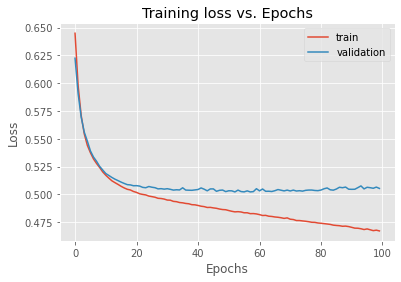

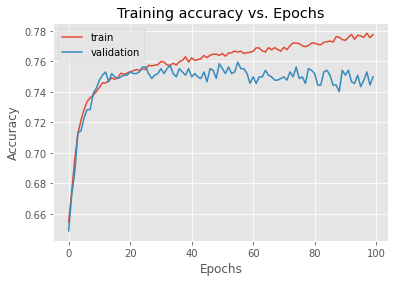

42/42 [==============================] - 0s 990us/step
Accuracy: 75.30%
F1 Score: 0.827623
Accuracy on mini_dem: 86.97%
F1 Score mini_dem: 0.930296

White FPR: 0.12514757969303425
Hispanic FPR: 0.14925373134328357
AA FPR: 0.23795180722891565
Other FPR: 0.011764705882352941


In [332]:
run(shallow_model(), 'shallow', epochs=100)

## Model 2: Deep NN

In [333]:
def deep_model():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)
    # embedded = keras.layers.Embedding(max_features+1, 300, weights=[embedding_matrix], trainable=False)

#     Accuracy: 76.36%
#     F1 Score: 0.833776
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_75 (Embedding)    (None, None, 100)         1609700   
                                                                 
 global_average_pooling1d_28  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_142 (Dense)           (None, 16)                1616      
                                                                 
 dense_143 (Dense)           (None, 16)                272       
                                                                 
 dense_144 (Dense)           (None, 1)                 17        
                                                                 
Total params: 1,611,605
Trainable params: 1,905
Non-trainable params: 1,609,700
_______________________________________

Epoch 50/100
262/262 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.7922 - val_loss: 0.5357 - val_accuracy: 0.7390
Epoch 51/100
262/262 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.7967 - val_loss: 0.5326 - val_accuracy: 0.7347
Epoch 52/100
262/262 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.7995 - val_loss: 0.5330 - val_accuracy: 0.7315
Epoch 53/100
262/262 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7983 - val_loss: 0.5386 - val_accuracy: 0.7347
Epoch 54/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7984 - val_loss: 0.5383 - val_accuracy: 0.7315
Epoch 55/100
262/262 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7972 - val_loss: 0.5365 - val_accuracy: 0.7368
Epoch 56/100
262/262 [==============================] - 0s 1ms/step - loss: 0.4356 - accuracy: 0.8012 - val_loss: 0.5388 - val_accuracy:

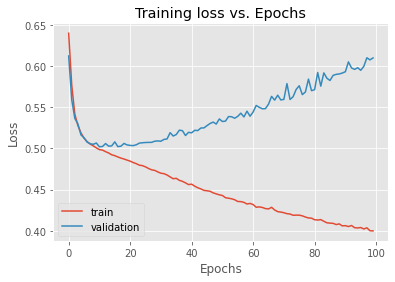

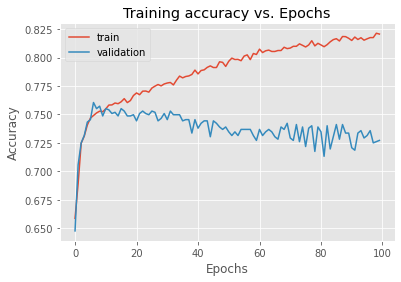

42/42 [==============================] - 0s 983us/step
Accuracy: 73.11%
F1 Score: 0.804610
Accuracy on mini_dem: 82.51%
F1 Score mini_dem: 0.904181

White FPR: 0.1754427390791027
Hispanic FPR: 0.16716417910447762
AA FPR: 0.2620481927710843
Other FPR: 0.0058823529411764705


In [334]:
run(deep_model(), 'deep_model', epochs=100)

## Model 3: Deeper NN with Dropout

In [792]:
def deeper_model():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)
#     Accuracy: 76.36%
#     F1 Score: 0.833776
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.8),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dropout(0.8),
      keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())

    return model

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_112 (Embedding)   (None, None, 100)         1609700   
                                                                 
 global_average_pooling1d_38  (None, 100)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_231 (Dense)           (None, 128)               12928     
                                                                 
 dropout_122 (Dropout)       (None, 128)               0         
                                                                 
 dense_232 (Dense)           (None, 64)                8256      
                                                                 
 dropout_123 (Dropout)       (None, 64)                0         
                                                    

Epoch 101/250
262/262 [==============================] - 0s 2ms/step - loss: 0.5530 - accuracy: 0.7256 - val_loss: 0.5181 - val_accuracy: 0.7487
Epoch 102/250
262/262 [==============================] - 0s 2ms/step - loss: 0.5552 - accuracy: 0.7187 - val_loss: 0.5183 - val_accuracy: 0.7487
Epoch 103/250
262/262 [==============================] - 1s 2ms/step - loss: 0.5526 - accuracy: 0.7238 - val_loss: 0.5192 - val_accuracy: 0.7508
Epoch 104/250
262/262 [==============================] - 1s 2ms/step - loss: 0.5513 - accuracy: 0.7269 - val_loss: 0.5161 - val_accuracy: 0.7508
Epoch 105/250
262/262 [==============================] - 1s 2ms/step - loss: 0.5464 - accuracy: 0.7243 - val_loss: 0.5163 - val_accuracy: 0.7454
Epoch 106/250
262/262 [==============================] - 1s 3ms/step - loss: 0.5564 - accuracy: 0.7237 - val_loss: 0.5170 - val_accuracy: 0.7626
Epoch 107/250
262/262 [==============================] - 1s 4ms/step - loss: 0.5548 - accuracy: 0.7183 - val_loss: 0.5170 - val_ac

262/262 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.7420 - val_loss: 0.5048 - val_accuracy: 0.7562
Epoch 214/250
262/262 [==============================] - 0s 2ms/step - loss: 0.5287 - accuracy: 0.7416 - val_loss: 0.5040 - val_accuracy: 0.7669
Epoch 215/250
262/262 [==============================] - 0s 2ms/step - loss: 0.5261 - accuracy: 0.7446 - val_loss: 0.5050 - val_accuracy: 0.7573
Epoch 216/250
262/262 [==============================] - 0s 2ms/step - loss: 0.5252 - accuracy: 0.7445 - val_loss: 0.5030 - val_accuracy: 0.7594
Epoch 217/250
262/262 [==============================] - 0s 2ms/step - loss: 0.5278 - accuracy: 0.7397 - val_loss: 0.5033 - val_accuracy: 0.7626
Epoch 218/250
262/262 [==============================] - 1s 2ms/step - loss: 0.5283 - accuracy: 0.7389 - val_loss: 0.5027 - val_accuracy: 0.7573
Epoch 219/250
262/262 [==============================] - 1s 2ms/step - loss: 0.5203 - accuracy: 0.7498 - val_loss: 0.5031 - val_accuracy: 0.7562

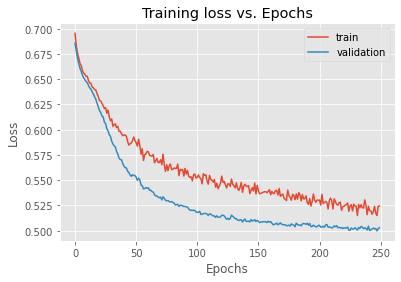

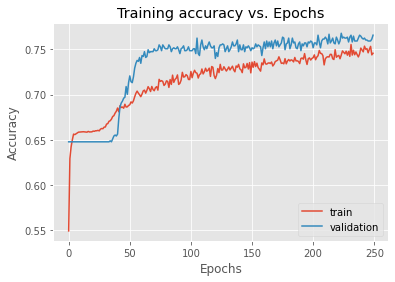

42/42 [==============================] - 0s 953us/step
Accuracy: 75.68%
F1 Score: 0.831942
Accuracy on mini_dem: 87.18%
F1 Score mini_dem: 0.931536

White FPR: 0.12349468713105077
Hispanic FPR: 0.15223880597014924
AA FPR: 0.2289156626506024
Other FPR: 0.0


In [803]:
run(deeper_model(), X_train=X_train, y_train=y_train, model_name='deeper', epochs=250)

## Model 4: RNN

In [337]:
def rnn():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1, activation='sigmoid')])


    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, None, 100)         1609700   
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 32)          4256      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, None, 32)          2080      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_150 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1,620,229
Trainable params: 10,529
Non-

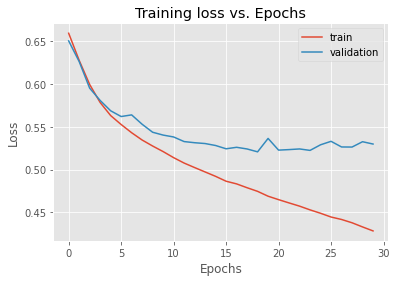

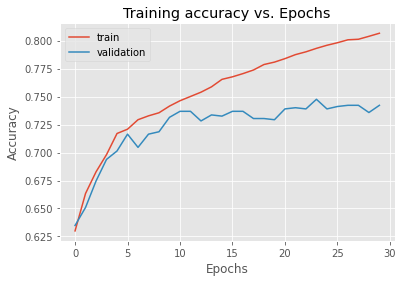

42/42 [==============================] - 1s 17ms/step
Accuracy: 74.40%
F1 Score: 0.819007
Accuracy on mini_dem: 86.59%
F1 Score mini_dem: 0.928149

White FPR: 0.13010625737898465
Hispanic FPR: 0.15522388059701492
AA FPR: 0.2289156626506024
Other FPR: 0.0058823529411764705


In [338]:
run(rnn(), 'rnn', epochs=30)

## Model 5: CNN

In [339]:
def cnn():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.Conv1D(100, 5, activation='relu'), # padding='same'
        keras.layers.Dropout(0.2),
        keras.layers.MaxPooling1D(pool_size=4),
        keras.layers.Conv1D(64, 5, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.MaxPooling1D(pool_size=4),
        keras.layers.Conv1D(32, 5, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_78 (Embedding)    (None, None, 100)         1609700   
                                                                 
 conv1d_30 (Conv1D)          (None, None, 100)         50100     
                                                                 
 dropout_62 (Dropout)        (None, None, 100)         0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 100)        0         
 1D)                                                             
                                                                 
 conv1d_31 (Conv1D)          (None, None, 64)          32064     
                                                                 
 dropout_63 (Dropout)        (None, None, 64)          0         
                                                     

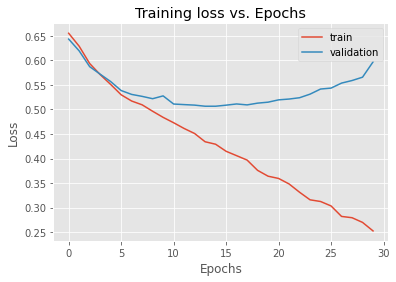

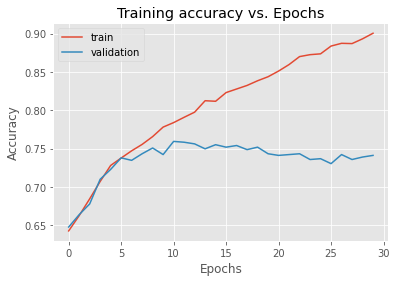

42/42 [==============================] - 0s 5ms/step
Accuracy: 75.68%
F1 Score: 0.830705
Accuracy on mini_dem: 83.40%
F1 Score mini_dem: 0.909482

White FPR: 0.16340023612750884
Hispanic FPR: 0.17313432835820897
AA FPR: 0.2680722891566265
Other FPR: 0.01764705882352941


In [340]:
run(cnn(), 'cnn', epochs=30)

## Model 6: RNN + LSTM

In [795]:
def lstm():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_109 (Embedding)   (None, None, 100)         1609700   
                                                                 
 lstm_22 (LSTM)              (None, 32)                17024     
                                                                 
 dropout_119 (Dropout)       (None, 32)                0         
                                                                 
 dense_228 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1,626,757
Trainable params: 17,057
Non-trainable params: 1,609,700
_________________________________________________________________
None
Epoch 1/30
262/262 [==============================] - 9s 27ms/step - loss: 0.6620 - accuracy: 0.6162 - val_loss: 0.6411 - val_accuracy: 0.6477
Epoch 2/30
262/262 [=

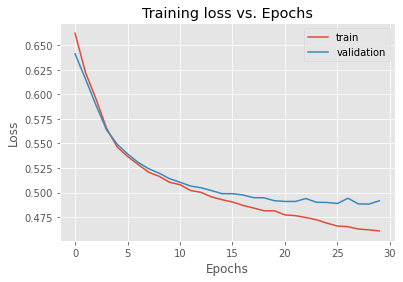

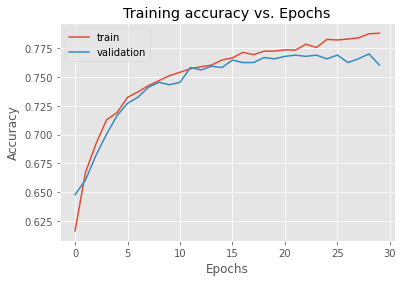

42/42 [==============================] - 1s 8ms/step
Accuracy: 76.06%
F1 Score: 0.827248
Accuracy on mini_dem: 85.55%
F1 Score mini_dem: 0.922112

White FPR: 0.13907910271546636
Hispanic FPR: 0.16417910447761194
AA FPR: 0.2680722891566265
Other FPR: 0.0


In [798]:
run(lstm(), X_train=X_train, y_train=y_train, model_name='lstm', epochs=30)

## Model 7: CNN + LSTM

In [343]:
def cnn_lstm():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.Conv1D(128, 5, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.MaxPooling1D(pool_size=4),
        keras.layers.LSTM(32),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_80 (Embedding)    (None, None, 100)         1609700   
                                                                 
 conv1d_33 (Conv1D)          (None, None, 128)         64128     
                                                                 
 dropout_66 (Dropout)        (None, None, 128)         0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 32)                20608     
                                                                 
 dense_153 (Dense)           (None, 1)                 33        
                                                     

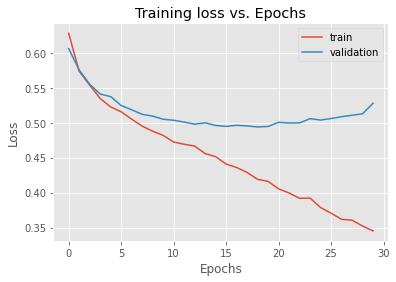

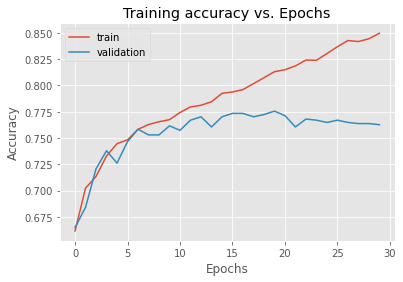

42/42 [==============================] - 1s 8ms/step
Accuracy: 77.42%
F1 Score: 0.842880
Accuracy on mini_dem: 85.06%
F1 Score mini_dem: 0.919241

White FPR: 0.14474616292798112
Hispanic FPR: 0.1701492537313433
AA FPR: 0.26506024096385544
Other FPR: 0.0


In [344]:
run(cnn_lstm(), 'cnn_lstm', epochs=30)

## Model 8: CNN + GRU

In [345]:
def cnn_gru():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.Conv1D(128, 5, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.MaxPooling1D(pool_size=4),
        keras.layers.GRU(64),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_81 (Embedding)    (None, None, 100)         1609700   
                                                                 
 conv1d_34 (Conv1D)          (None, None, 128)         64128     
                                                                 
 dropout_67 (Dropout)        (None, None, 128)         0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 gru_33 (GRU)                (None, 64)                37248     
                                                                 
 dense_154 (Dense)           (None, 1)                 65        
                                                     

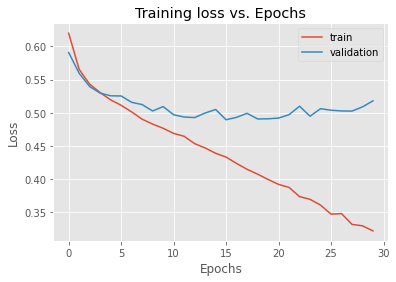

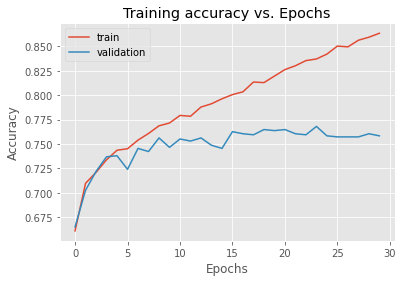

42/42 [==============================] - 1s 6ms/step
Accuracy: 76.96%
F1 Score: 0.841394
Accuracy on mini_dem: 86.30%
F1 Score mini_dem: 0.926447

White FPR: 0.13128689492325857
Hispanic FPR: 0.15522388059701492
AA FPR: 0.2620481927710843
Other FPR: 0.0


In [346]:
run(cnn_gru(), 'cnn_gru', epochs=30)

## Model 9: RNN + GRU

In [347]:
def rnn_gru():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.GRU(64),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_82 (Embedding)    (None, None, 100)         1609700   
                                                                 
 gru_34 (GRU)                (None, 64)                31872     
                                                                 
 dropout_68 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 1)                 65        
                                                                 
Total params: 1,641,637
Trainable params: 31,937
Non-trainable params: 1,609,700
_________________________________________________________________
None
Epoch 1/30
262/262 [==============================] - 11s 36ms/step - loss: 0.6579 - accuracy: 0.6116 - val_loss: 0.6337 - val_accuracy: 0.6692
Epoch 2/30
262/262 [=

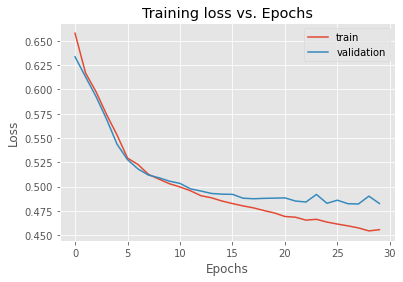

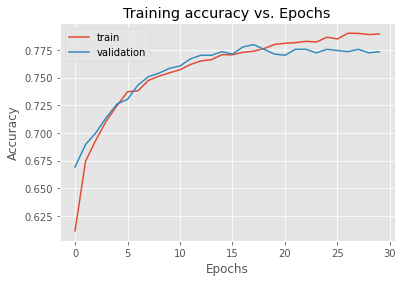

42/42 [==============================] - 1s 11ms/step
Accuracy: 76.81%
F1 Score: 0.836962
Accuracy on mini_dem: 88.21%
F1 Score mini_dem: 0.937356

White FPR: 0.11216056670602124
Hispanic FPR: 0.1253731343283582
AA FPR: 0.24397590361445784
Other FPR: 0.0


In [348]:
run(rnn_gru(), 'rnn_gru', epochs=30)

## Model 10: Bidirectional RNN

In [799]:
def bi_rnn():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.SimpleRNN(32)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_110 (Embedding)   (None, None, 100)         1609700   
                                                                 
 bidirectional_69 (Bidirecti  (None, None, 64)         8512      
 onal)                                                           
                                                                 
 bidirectional_70 (Bidirecti  (None, None, 64)         6208      
 onal)                                                           
                                                                 
 bidirectional_71 (Bidirecti  (None, None, 64)         6208      
 onal)                                                           
                                                                 
 bidirectional_72 (Bidirecti  (None, 64)               6208      
 onal)                                              

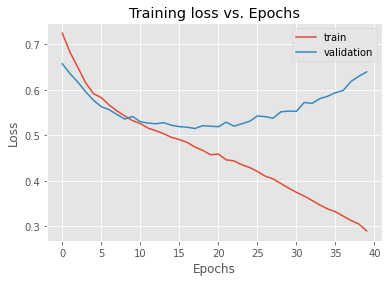

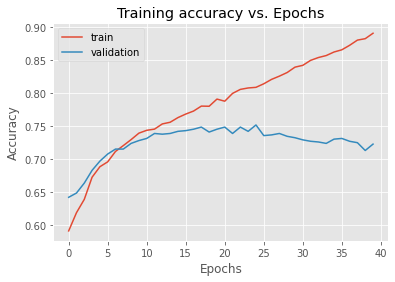

42/42 [==============================] - 2s 28ms/step
Accuracy: 73.49%
F1 Score: 0.813199
Accuracy on mini_dem: 84.84%
F1 Score mini_dem: 0.917973

White FPR: 0.14403778040141677
Hispanic FPR: 0.14328358208955225
AA FPR: 0.25
Other FPR: 0.16470588235294117


In [800]:
run(bi_rnn(), X_train=X_train, y_train=y_train, model_name='bi_rnn', epochs=40)

## Model 11: Bidirectional LSTM

In [801]:
def bi_lstm():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_111 (Embedding)   (None, None, 100)         1609700   
                                                                 
 bidirectional_73 (Bidirecti  (None, 128)              84480     
 onal)                                                           
                                                                 
 dropout_121 (Dropout)       (None, 128)               0         
                                                                 
 dense_230 (Dense)           (None, 1)                 129       
                                                                 
Total params: 1,694,309
Trainable params: 84,609
Non-trainable params: 1,609,700
_________________________________________________________________
None
Epoch 1/30
262/262 [==============================] - 20s 65ms/step - loss: 0.6290 - accuracy: 0.6

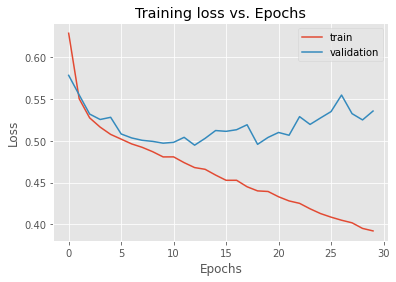

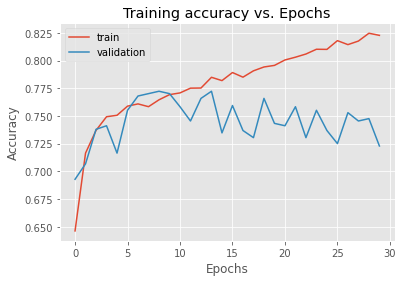

42/42 [==============================] - 1s 17ms/step
Accuracy: 74.70%
F1 Score: 0.808681
Accuracy on mini_dem: 82.29%
F1 Score mini_dem: 0.902877

White FPR: 0.1730814639905549
Hispanic FPR: 0.16716417910447762
AA FPR: 0.31626506024096385
Other FPR: 0.023529411764705882


In [802]:
run(bi_lstm(), X_train=X_train, y_train=y_train, model_name='bi_lstm', epochs=30)

## Model 12: Bidirectional GRU

In [353]:
def bi_gru():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.Bidirectional(keras.layers.GRU(64)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_85 (Embedding)    (None, None, 100)         1609700   
                                                                 
 bidirectional_46 (Bidirecti  (None, 128)              63744     
 onal)                                                           
                                                                 
 dropout_71 (Dropout)        (None, 128)               0         
                                                                 
 dense_158 (Dense)           (None, 1)                 129       
                                                                 
Total params: 1,673,573
Trainable params: 63,873
Non-trainable params: 1,609,700
_________________________________________________________________
None
Epoch 1/30
262/262 [==============================] - 20s 63ms/step - loss: 0.6420 - accuracy: 0.64

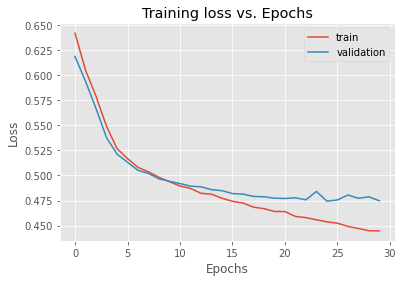

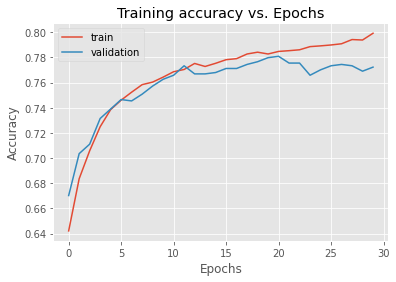

42/42 [==============================] - 6s 30ms/step
Accuracy: 77.49%
F1 Score: 0.840812
Accuracy on mini_dem: 87.16%
F1 Score mini_dem: 0.931423

White FPR: 0.12231404958677686
Hispanic FPR: 0.14626865671641792
AA FPR: 0.25301204819277107
Other FPR: 0.0


In [354]:
run(bi_gru(), 'bi_gru', epochs=30)

## Model 13: Recurrent CNN

In [355]:
def recurrent_cnn():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True)),
        keras.layers.Convolution1D(64, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_23 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_47 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 conv1d_35 (Conv1D)          (None, None, 64)          24640     
                                                                 
 global_max_pooling1d_25 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                     

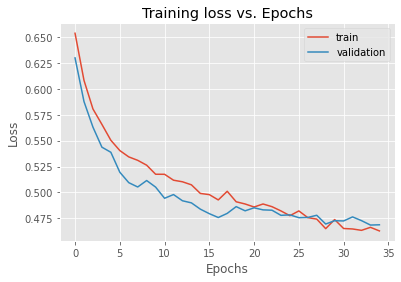

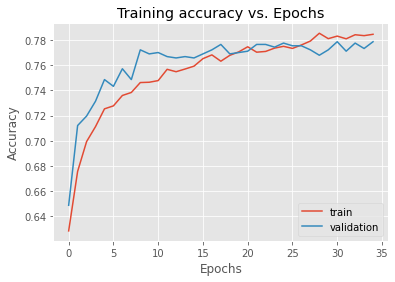

42/42 [==============================] - 3s 24ms/step
Accuracy: 78.93%
F1 Score: 0.850562
Accuracy on mini_dem: 84.50%
F1 Score mini_dem: 0.916008

White FPR: 0.1511216056670602
Hispanic FPR: 0.1701492537313433
AA FPR: 0.2680722891566265
Other FPR: 0.0


In [356]:
run(recurrent_cnn(), 'recurrent_cnn', epochs=35)

In [357]:
best_model = keras.models.load_model('test_model_best.h5')

In [358]:
evaluate(best_model, 'best_model')

42/42 [==============================] - 3s 20ms/step
Accuracy: 59.52%
F1 Score: 0.713675
Accuracy on mini_dem: 85.02%
F1 Score mini_dem: 0.919011

White FPR: 0.15726092089728452
Hispanic FPR: 0.1253731343283582
AA FPR: 0.10843373493975904
Other FPR: 0.09411764705882353


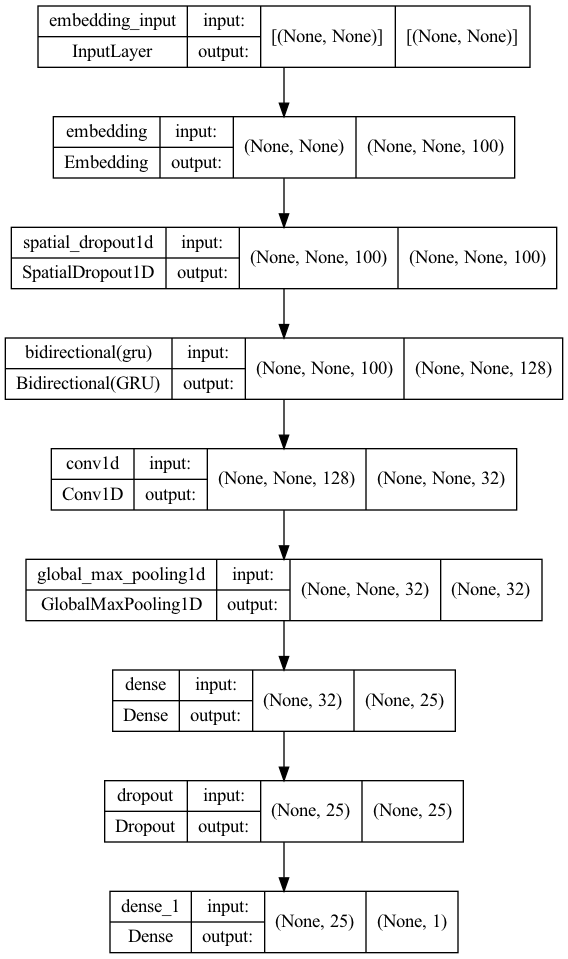

In [359]:
keras.utils.vis_utils.plot_model(best_model, show_shapes=True, show_layer_names=True)

In [360]:
#best_model.get_layer(index=8).get_config()

for i in range(len(best_model.layers)):
    if best_model.get_layer(index=i).get_config() != rcnn.get_layer(index=i).get_config():
        print(rcnn.get_layer(index=i).get_config())


{'name': 'embedding_36', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 16097, 'output_dim': 100, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}
{'name': 'spatial_dropout1d_17', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'noise_shape': None, 'seed': None}
{'name': 'bidirectional_26', 'trainable': True, 'dtype': 'float32', 'layer': {'class_name': 'GRU', 'config': {'name': 'gru_20', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer'

In [361]:
rcnn = recurrent_cnn()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_87 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_24 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_48 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 conv1d_36 (Conv1D)          (None, None, 64)          24640     
                                                                 
 global_max_pooling1d_26 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                     

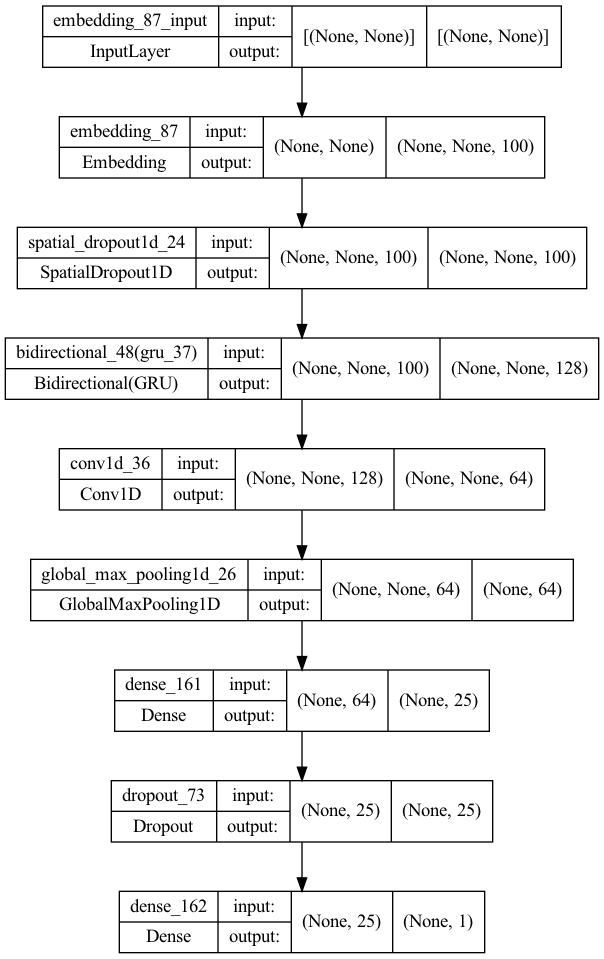

In [362]:
keras.utils.vis_utils.plot_model(rcnn, show_shapes=True, show_layer_names=True)

In [363]:
def recurrent_cnn_random():
    embedded = keras.layers.Embedding(max_features, embedding_dim)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True)),
        keras.layers.Convolution1D(32, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_88 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_25 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_49 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 conv1d_37 (Conv1D)          (None, None, 32)          12320     
                                                                 
 global_max_pooling1d_27 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                     

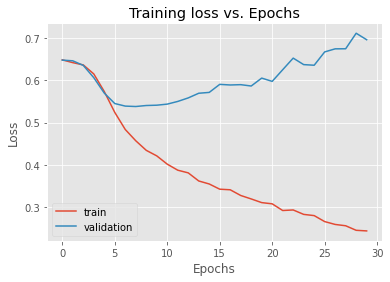

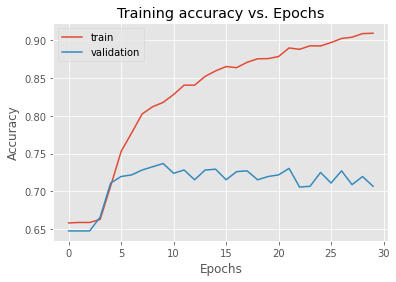

42/42 [==============================] - 1s 13ms/step
Accuracy: 73.87%
F1 Score: 0.810929
Accuracy on mini_dem: 83.18%
F1 Score mini_dem: 0.908191

White FPR: 0.1617473435655254
Hispanic FPR: 0.18507462686567164
AA FPR: 0.29518072289156627
Other FPR: 0.047058823529411764


In [364]:
run(recurrent_cnn_random(), 'recurrent_cnn_random', epochs=30)

## Model 14: Recurrent CNN1

In [375]:
def recurrent_cnn1():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)),
        keras.layers.Convolution1D(32, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_94 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_30 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_56 (Bidirecti  (None, None, 64)         34048     
 onal)                                                           
                                                                 
 conv1d_42 (Conv1D)          (None, None, 32)          6176      
                                                                 
 global_max_pooling1d_32 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                     

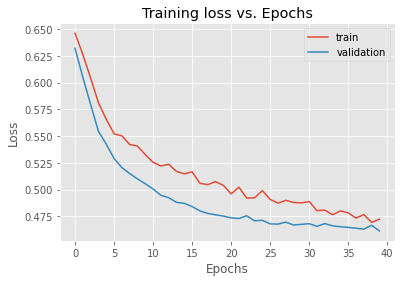

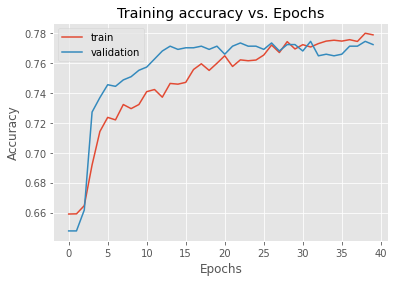

42/42 [==============================] - 1s 10ms/step
Accuracy: 78.32%
F1 Score: 0.845616
Accuracy on mini_dem: 84.88%
F1 Score mini_dem: 0.918204

White FPR: 0.14687131050767416
Hispanic FPR: 0.16716417910447762
AA FPR: 0.2680722891566265
Other FPR: 0.0


In [376]:
run(recurrent_cnn1(), 'recurrent_cnn1', epochs=40)

## Model 15: Recurrent CNN2

In [367]:
def recurrent_cnn2():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
        keras.layers.Convolution1D(32, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.40),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_27 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_51 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 bidirectional_52 (Bidirecti  (None, None, 128)        74496     
 onal)                                                           
                                                                 
 conv1d_39 (Conv1D)          (None, None, 32)          12320     
                                                     

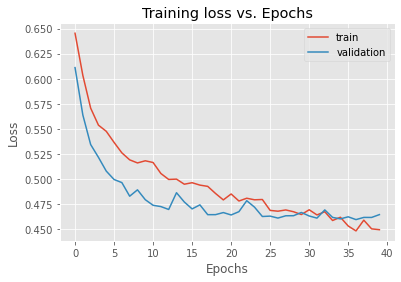

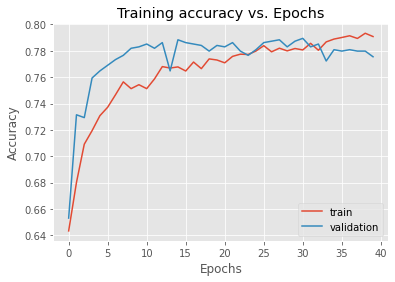

42/42 [==============================] - 2s 23ms/step
Accuracy: 79.68%
F1 Score: 0.856380
Accuracy on mini_dem: 84.86%
F1 Score mini_dem: 0.918089

White FPR: 0.14687131050767416
Hispanic FPR: 0.1701492537313433
AA FPR: 0.26506024096385544
Other FPR: 0.0058823529411764705


In [368]:
run(recurrent_cnn2(), 'recurrent_cnn2', epochs=40)

In [939]:
best_model = keras.models.load_model('recurrent_cnn1.h5')

In [940]:
evaluate(best_model, batch_size=len(X_test))

8/8 [==============================] - 3s 242ms/step
Train Accuracy: 79.66%
Train F1 Score: 0.852418
1/1 [==============================] - 1s 868ms/step
Accuracy: 78.32%
F1 Score: 0.845616
Accuracy on mini_dem: 84.88%
F1 Score mini_dem: 0.918204

White FPR: 0.14687131050767416
Hispanic FPR: 0.16716417910447762
AA FPR: 0.2680722891566265
Other FPR: 0.0


In [941]:
import pickle

filename = 'race_model.sav'
# pickle.dump(logr, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
get_race = pickle.load(open(filename, 'rb'))

In [942]:
dem = pd.DataFrame()
dem['text'] = xtde
dem['label'] = ytde
dem

,text,label
0,people make mistakes takes good person learn l...,1
1,one road power cable internet guess not,1
2,love baby yawn think cute,1
3,theres many hoes actually think,1
4,today day adalynn alexis not believe number mo...,1
...,...,...
5067,favorite seat cambus single one back overlooks...,1
5068,haha,1
5069,straight relaxin right,1
5070,una bala mas aire,1


In [943]:
uniform = [0.25, 0.25, 0.25, 0.25]
dist = lambda x: np.sqrt(np.sum(np.square(x - uniform)))

In [1026]:
probs = get_race.predict_proba(dem['text'])
dem['race'] = [x for x in probs]
varss = [np.std(x) for x in dem['race'].values]
dem['lambda'] = varss

In [1027]:
dem

,text,label,race,lambda,pred,final_pred,pred_label,net_pred,dem
0,people make mistakes takes good person learn l...,1,"[0.08882822483660359, 0.4140847422065007, 0.00...",0.209583,0.923268,0.837981,1,1,White
1,one road power cable internet guess not,1,"[0.16363711701688377, 0.10807288972832205, 0.0...",0.280739,0.925878,0.870471,1,1,White
2,love baby yawn think cute,1,"[0.16817508635224418, 0.6526162423580347, 0.00...",0.242887,0.964651,0.886892,1,1,White
3,theres many hoes actually think,1,"[0.1236687298458153, 0.5362901511942896, 0.001...",0.204788,0.927457,0.839890,1,1,White
4,today day adalynn alexis not believe number mo...,1,"[0.03992739344782069, 0.6484418266345365, 2.13...",0.259409,0.985826,0.912428,1,1,White
...,...,...,...,...,...,...,...,...,...
5067,favorite seat cambus single one back overlooks...,1,"[0.13983208751915163, 0.18230225544472586, 0.0...",0.255457,0.921337,0.854791,1,1,White
5068,haha,1,"[2.967985607067021e-05, 0.6160165675779754, 0....",0.254994,0.897558,0.833985,1,1,White
5069,straight relaxin right,1,"[0.35348563877276773, 0.3283878201280321, 0.01...",0.134993,0.672292,0.598266,1,1,White
5070,una bala mas aire,1,"[0.003283857176429411, 0.016851569999438192, 0...",0.420330,0.879350,0.914947,1,1,Hispanic


In [1028]:
preds = best_model.predict(X_test_dev)

In [1029]:
dem['pred'] = preds

In [1030]:
dem['final_pred'] = dem['lambda'] + dem['pred']

In [1031]:
dem['final_pred'] = dem['final_pred'] / max(dem['final_pred'] )

In [1032]:
dem.sort_values('lambda')

,text,label,race,lambda,pred,final_pred,pred_label,net_pred,dem
1574,oooooor come fairfield happy,1,"[0.2589606221777801, 0.24990799792117013, 0.23...",0.010561,0.950249,0.688264,1,1,White
1389,blowww meeee wanttttttt,1,"[0.23249497683886808, 0.27592774930265956, 0.2...",0.021517,0.879350,0.645324,1,1,White
2454,diante download app,1,"[0.2639659589147807, 0.2447657735981655, 0.214...",0.023383,0.929435,0.682540,1,1,AA
158,subliminally raped,1,"[0.22588235026793285, 0.24735935855966532, 0.2...",0.024495,0.428448,0.324460,0,0,White
903,upppp,1,"[0.2809191519844461, 0.214852590302821, 0.2162...",0.034522,0.879350,0.654641,1,1,AA
...,...,...,...,...,...,...,...,...,...
4074,mal morena esos est feo que cepeda rolo los or...,1,"[0.0004319610311753855, 0.0035373954636157665,...",0.430321,0.931935,0.975836,1,1,Other
2115,cantearon que sabes que los chinos son agarrao...,1,"[3.789386358615899e-05, 0.0042265301724303105,...",0.430550,0.902830,0.955150,1,1,Other
4356,nunca deci pero ahora gente tiene hacer reflex...,1,"[0.00017574264023496959, 0.002803390645877402,...",0.431203,0.926453,0.972540,1,1,Other
2403,ion got hoes lol,1,"[0.9986599435529668, 0.0012524857026418106, 3....",0.432239,0.866962,0.930667,1,1,AA


In [1033]:
dem['pred_label'] = [0 if x < 0.5 else 1 for x in dem['final_pred']]

In [1034]:
dem['net_pred'] = [0 if x < 0.5 else 1 for x in dem['pred']]

In [1035]:
dem

,text,label,race,lambda,pred,final_pred,pred_label,net_pred,dem
0,people make mistakes takes good person learn l...,1,"[0.08882822483660359, 0.4140847422065007, 0.00...",0.209583,0.923268,0.811504,1,1,White
1,one road power cable internet guess not,1,"[0.16363711701688377, 0.10807288972832205, 0.0...",0.280739,0.925878,0.864345,1,1,White
2,love baby yawn think cute,1,"[0.16817508635224418, 0.6526162423580347, 0.00...",0.242887,0.964651,0.865005,1,1,White
3,theres many hoes actually think,1,"[0.1236687298458153, 0.5362901511942896, 0.001...",0.204788,0.927457,0.811070,1,1,White
4,today day adalynn alexis not believe number mo...,1,"[0.03992739344782069, 0.6484418266345365, 2.13...",0.259409,0.985826,0.892009,1,1,White
...,...,...,...,...,...,...,...,...,...
5067,favorite seat cambus single one back overlooks...,1,"[0.13983208751915163, 0.18230225544472586, 0.0...",0.255457,0.921337,0.842981,1,1,White
5068,haha,1,"[2.967985607067021e-05, 0.6160165675779754, 0....",0.254994,0.897558,0.825617,1,1,White
5069,straight relaxin right,1,"[0.35348563877276773, 0.3283878201280321, 0.01...",0.134993,0.672292,0.578288,1,1,White
5070,una bala mas aire,1,"[0.003283857176429411, 0.016851569999438192, 0...",0.420330,0.879350,0.931009,1,1,Hispanic


In [1036]:
print(classification_report(dem['label'], dem['pred_label']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.92      5072

    accuracy                           0.86      5072
   macro avg       0.50      0.43      0.46      5072
weighted avg       1.00      0.86      0.92      5072



In [1037]:
dem['dem'] = mini_demographic_dev["demographic"]

In [1038]:
len(dem[dem['pred_label'] == 1]) / len(dem[dem['label'] == 1])

0.8588328075709779

In [1039]:
mini_demographic_dev["pred_label"] = dem['pred_label']

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)


White FPR: 0.13648170011806376
Hispanic FPR: 0.1701492537313433
AA FPR: 0.24397590361445784
Other FPR: 0.0


In [927]:
races = get_race.predict_proba(dev.text)
dev['races'] = [x for x in races]

In [928]:
dev[dev['bin_label']==1][dev['preds']<0.5][dev['final_pred']>0.5].sort_values('lambda')

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
695,bad california common sense gun control laws p...,NOT,NaN,0.380077,"[0.05304460958522476, 0.3378724426225952, 0.01...",0.053711,0.483787,0.537498,1,1,0.053711,3
232,happens tell white liberals not get congratula...,NOT,NaN,0.738868,"[0.21040026928240899, 0.13610829153422171, 0.0...",0.059900,0.491910,0.551811,1,1,0.059900,3
155,titles scare little bit wink,NOT,NaN,0.301076,"[0.015703618012766526, 0.6204282418851366, 0.0...",0.063850,0.481940,0.545790,1,1,0.063850,1
385,gun control anyone disarm hate,NOT,NaN,0.369393,"[0.0485300198501664, 0.27408629379897403, 0.00...",0.070859,0.440885,0.511744,1,1,0.070859,3
1097,morphed antifa antifa gets better coverage imp...,NOT,NaN,0.532200,"[0.10132923756472405, 0.1876007347169165, 0.00...",0.075059,0.476616,0.551675,1,1,0.075059,3
1317,elon smoking much dope apparently got bad batc...,NOT,NaN,0.496995,"[0.07333551680001435, 0.22029880142418576, 8.0...",0.075687,0.471457,0.547144,1,1,0.075687,3
212,another terrorist attack not reported msm,NOT,NaN,0.582354,"[0.11582869776901007, 0.10683429860633765, 0.0...",0.080731,0.491714,0.572444,1,1,0.080731,3
744,party bill clinton ted kennedy accusing brett ...,NOT,NaN,0.386466,"[0.14266676720360896, 0.09779932657008689, 0.0...",0.084960,0.493367,0.578327,1,1,0.084960,3
405,sjw crap paedophilia hollywood movies gaming p...,NOT,NaN,0.831707,"[0.08197934431132615, 0.13311890137281324, 0.0...",0.089581,0.470571,0.560152,1,1,0.089581,3
987,said complains fox news nothing like trump war...,NOT,NaN,0.531110,"[0.07571873160281445, 0.1571775750333139, 0.00...",0.091987,0.422881,0.514868,1,1,0.091987,3


In [929]:
dev[dev['bin_label']==0][dev['preds']<0.5][dev['final_pred']>0.5].sort_values('lambda')

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
989,funny human rights pro abortion settles lies p...,OFF,TIN,0.669928,"[0.10155916160254462, 0.31055003185115965, 0.0...",0.033648,0.498359,0.532007,1,0,0.033648,3
233,antifa not beat facsists try get change mind k...,OFF,TIN,0.359225,"[0.1508974248153941, 0.3437905767347701, 0.000...",0.036545,0.488132,0.524677,1,0,0.036545,3
500,thank fortitude perseverance please give mccon...,OFF,TIN,0.607978,"[0.10529549350730708, 0.32551089906605507, 0.0...",0.043667,0.480779,0.524446,1,0,0.043667,3
1081,destroying excuse beat time bullshitting also ...,OFF,TIN,0.837852,"[0.14965812905148485, 0.22245381267036224, 0.0...",0.050439,0.473357,0.523796,1,0,0.050439,3
391,wonder many children molested,OFF,TIN,0.700972,"[0.203192079729974, 0.16266516767299902, 0.010...",0.051572,0.458630,0.510201,1,0,0.051572,3
649,care murdered not care whether weed home like ...,OFF,TIN,0.738868,"[0.04993680675266273, 0.3456753774958296, 0.00...",0.059100,0.465344,0.524444,1,0,0.059100,3
707,total mental breakdown elected,OFF,TIN,0.709115,"[0.024431534523454927, 0.0688612594492702, 0.2...",0.063731,0.456588,0.520319,1,0,0.063731,3
120,please not kill antifa hand,OFF,TIN,0.521736,"[0.11522415533774268, 0.2028017918007192, 0.00...",0.067095,0.448675,0.515770,1,0,0.067095,3
62,grateful trump dog white house cruel man,OFF,TIN,0.566570,"[0.17215848300635125, 0.11853948305505886, 0.0...",0.071003,0.429173,0.500176,1,0,0.071003,3
928,thus far people getting shot kicked places con...,OFF,TIN,0.536464,"[0.09246815344039237, 0.2088391305260997, 0.00...",0.071289,0.495168,0.566457,1,0,0.071289,3


In [930]:
varss = [np.var(x) for x in dev['races'].values]
dev['lambda'] = varss

In [931]:
preds = best_model.predict(X_test)
dev['preds'] = preds
dev[dev['preds'] < 0.5]

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
3,someone havetaken piece shit volcano,OFF,UNT,0.927032,"[0.09196395626760362, 0.230271477588789, 0.054...",0.050809,0.128740,0.099781,0,0,0.050809,3
6,noes tough shit,OFF,UNT,0.929462,"[0.4278840451033617, 0.2195951470912396, 0.045...",0.019456,0.142901,0.109654,0,0,0.019456,0
7,literally talking lol mass shootings like set ...,OFF,TIN,0.346358,"[0.09962348959464894, 0.15702613162225745, 0.0...",0.083829,0.471977,0.624355,1,0,0.083829,3
12,lying corrupt traitor nobody wants hear anymor...,OFF,TIN,0.954729,"[0.23871248754510235, 0.09054888584791054, 0.0...",0.065277,0.114621,0.199380,0,0,0.065277,3
20,lol throwing bullshit flag nonsense put shut k...,OFF,TIN,0.933478,"[0.19606818783816787, 0.4469823068378535, 0.00...",0.028777,0.111277,0.192841,0,0,0.028777,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1302,running away truth yet using childish language...,NOT,NaN,0.456016,"[0.11873307513482027, 0.16362988882332824, 0.0...",0.075506,0.333849,0.586933,1,1,0.075506,3
1305,not first time expressed dismissive attitude t...,OFF,TIN,0.623295,"[0.10408826733303056, 0.18607361658152735, 0.0...",0.074037,0.143236,0.255929,0,0,0.074037,3
1310,people msm disgusting maga,NOT,NaN,0.866405,"[0.055436967576015704, 0.22997045105870959, 0....",0.017982,0.156341,0.237063,0,1,0.017982,3
1312,fuck tmi queen things controls conversation su...,OFF,TIN,0.899301,"[0.19986631859134193, 0.2231359233975217, 0.00...",0.042606,0.172038,0.184389,0,0,0.042606,3


In [932]:
dev['final_pred'] = dev['lambda'] + dev['preds']

In [933]:
dev['final_pred'] = dev['final_pred']

In [934]:
dev['pred_label'] = [0 if x < 0.5 else 1 for x in dev['final_pred']]

In [935]:
dev['bin_label'] = [0 if x=='OFF' else 1 for x in dev['label']]

In [936]:
print(classification_report(dev['pred_label'], dev['bin_label']))

              precision    recall  f1-score   support

           0       0.51      0.78      0.62       290
           1       0.93      0.79      0.86      1034

    accuracy                           0.79      1324
   macro avg       0.72      0.79      0.74      1324
weighted avg       0.84      0.79      0.80      1324



In [937]:
print(accuracy_score(dev['pred_label'], dev['bin_label']))

0.7900302114803626


In [938]:
print(f1_score(dev['pred_label'], dev['bin_label']))

0.8550573514077165


In [903]:
dev['diff'] = abs(dev['final_pred'] - dev['preds'])
dev[dev['final_pred'] > 0.5][dev['preds'] < 0.5]

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
48,holy moly catholic people not awakened false p...,NOT,NaN,0.730408,"[0.014228794702405229, 0.12321090678692224, 0....",0.108026,0.406391,0.514417,1,1,0.108026,3
54,number number british people basically full ra...,OFF,TIN,0.531270,"[0.017709885360667605, 0.20086514055633256, 0....",0.072259,0.492067,0.564326,1,0,0.072259,3
62,grateful trump dog white house cruel man,OFF,TIN,0.566570,"[0.17215848300635125, 0.11853948305505886, 0.0...",0.071003,0.429173,0.500176,1,0,0.071003,3
120,please not kill antifa hand,OFF,TIN,0.521736,"[0.11522415533774268, 0.2028017918007192, 0.00...",0.067095,0.448675,0.515770,1,0,0.067095,3
155,titles scare little bit wink,NOT,NaN,0.301076,"[0.015703618012766526, 0.6204282418851366, 0.0...",0.063850,0.481940,0.545790,1,1,0.063850,1
209,please shut ontario seeing conservatives stand...,NOT,NaN,0.719293,"[0.02461580214509833, 0.21789185953265047, 3.3...",0.092957,0.457104,0.550061,1,1,0.092957,3
212,another terrorist attack not reported msm,NOT,NaN,0.582354,"[0.11582869776901007, 0.10683429860633765, 0.0...",0.080731,0.491714,0.572444,1,1,0.080731,3
226,could killed many hunting rifle time vantage c...,NOT,NaN,0.470670,"[0.047605846465811744, 0.0744391912838141, 0.0...",0.132107,0.493278,0.625385,1,1,0.132107,3
232,happens tell white liberals not get congratula...,NOT,NaN,0.738868,"[0.21040026928240899, 0.13610829153422171, 0.0...",0.059900,0.491910,0.551811,1,1,0.059900,3
233,antifa not beat facsists try get change mind k...,OFF,TIN,0.359225,"[0.1508974248153941, 0.3437905767347701, 0.000...",0.036545,0.488132,0.524677,1,0,0.036545,3


In [904]:
dev.sort_values('lambda')

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
419,url,NOT,NaN,0.035729,"[0.2789718260063021, 0.20426914768743876, 0.23...",0.001045,0.931047,0.932092,1,1,0.001045,3
867,going heartbroken see number followers bot bot...,NOT,NaN,0.241042,"[0.3014041841491265, 0.1830958772333385, 0.290...",0.002360,0.985229,0.987589,1,1,0.002360,0
977,hollywood finest,NOT,NaN,0.032622,"[0.1834804651028315, 0.2326037647471725, 0.321...",0.002508,0.901883,0.904391,1,1,0.002508,2
261,deserving woman happy,NOT,NaN,0.076959,"[0.20139341887209986, 0.20403207744533997, 0.2...",0.002513,0.967957,0.970470,1,1,0.002513,3
698,shut wanker,OFF,TIN,0.892049,"[0.23075168100099125, 0.31900819787945855, 0.1...",0.002564,0.227791,0.230355,0,0,0.002564,1
...,...,...,...,...,...,...,...,...,...,...,...,...
478,awful,OFF,TIN,0.730683,"[0.030067450368735153, 0.0033864240074244797, ...",0.148800,0.458567,0.607366,1,0,0.148800,3
1292,dead ass serious smdh,NOT,NaN,0.890875,"[0.9300218206410918, 0.04534349848342022, 0.00...",0.154394,0.038493,0.192887,0,1,0.154394,0
1111,ben terrible person probably raped people vial...,OFF,TIN,0.651947,"[0.030247662180394482, 0.03127711325809487, 0....",0.157497,0.341413,0.498910,0,0,0.157497,3
1095,head bout big shit,OFF,TIN,0.978557,"[0.9413387527674307, 0.02809461883474264, 5.22...",0.159460,0.072231,0.231691,0,0,0.159460,0


In [687]:
dev['race_label'] = [np.argmax(x) for x in dev['races']]

In [688]:
dev

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
0,ask native americans take,OFF,UNT,0.311852,"[0.19877705766373116, 0.13819121307656146, 0.0...",0.053881,0.923206,0.977088,1,0,0.053881,3
1,home drunk maga trump url,OFF,TIN,0.566334,"[0.16439720076558045, 0.20993735749988698, 0.0...",0.029256,0.613706,0.642963,1,0,0.029256,3
2,amazon investigating chinese employees selling...,NOT,NaN,0.110361,"[0.08395594326471259, 0.13322262329314433, 0.1...",0.057987,0.945842,1.003829,1,1,0.057987,3
3,someone havetaken piece shit volcano,OFF,UNT,0.927032,"[0.09196395626760362, 0.230271477588789, 0.054...",0.050809,0.048972,0.099781,0,0,0.050809,3
4,obama wanted liberals illegals move red states,NOT,NaN,0.319764,"[0.12111451214946435, 0.12567025457470254, 0.0...",0.065075,0.857418,0.922493,1,1,0.065075,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1319,mazzone convinced play nfl told acts like good...,NOT,NaN,0.120313,"[0.1688827962949082, 0.2797826742267066, 0.002...",0.039530,0.617990,0.657520,1,1,0.039530,3
1320,course maga everyone,NOT,NaN,0.192485,"[0.01638803894647104, 0.25452959156601745, 0.0...",0.068772,0.942293,1.011065,1,1,0.068772,3
1321,not bizarre smart business gonna get paid some...,NOT,NaN,0.323090,"[0.018019448582904916, 0.0700758217229667, 1.5...",0.146694,0.884483,1.031177,1,1,0.146694,3
1322,follow maga patriots got couple new ones tweee...,NOT,NaN,0.308332,"[0.2483955883782214, 0.14852199180238054, 0.00...",0.049225,0.908909,0.958134,1,1,0.049225,3


In [689]:
dev[dev.race_label == 0]

,text,label,category,perspective_score,races,lambda,preds,final_pred,pred_label,bin_label,diff,race_label
6,noes tough shit,OFF,UNT,0.929462,"[0.4278840451033617, 0.2195951470912396, 0.045...",0.019456,0.090199,0.109654,0,0,0.019456,0
19,gun control kids asking,OFF,TIN,0.173885,"[0.42397974748336537, 0.20348998689264505, 0.0...",0.025834,0.835774,0.861608,1,0,0.025834,0
27,tell hooper,NOT,NaN,0.384874,"[0.3886701075720427, 0.30426080040488185, 0.13...",0.010455,0.935102,0.945557,1,1,0.010455,0
44,ppl say not racist racist racist repeat,NOT,NaN,0.786152,"[0.4444072799441167, 0.12244065419288544, 0.01...",0.033410,0.074495,0.107905,0,1,0.033410,0
63,lying stick facts pay,NOT,NaN,0.532205,"[0.46860395406264826, 0.2696175415227618, 0.00...",0.026755,0.535721,0.562476,1,1,0.026755,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1223,sis mandys nose havin ass grim adventures bill...,OFF,TIN,0.899760,"[0.645251345837501, 0.10066011559941537, 0.007...",0.059305,0.059714,0.119019,0,0,0.059305,0
1271,team even know ass,OFF,TIN,0.918961,"[0.6280767762465075, 0.2191514932210601, 0.001...",0.053870,0.114049,0.167919,0,0,0.053870,0
1277,funny want gun control partner snoop dog,NOT,NaN,0.377039,"[0.40850749236417067, 0.2562177778330828, 0.00...",0.023472,0.641252,0.664724,1,1,0.023472,0
1289,god maga block buhbye,NOT,NaN,0.325957,"[0.3854970682817682, 0.24472218909330667, 0.13...",0.007885,0.865846,0.873731,1,1,0.007885,0


In [709]:
train['race'] = get_race.predict(train.text.values)

In [725]:
train['bin_label'] = [0 if x=='OFF' else 1 for x in train.label.values]
train

,text,label,category,len,race,bin_label
1,seems hard believe stood next guy wearing shor...,OFF,TIN,12,3,0
2,wow wonder liberals got worse party bullies wo...,OFF,TIN,9,3,0
3,not idiots grandstands like,OFF,TIN,4,1,0
4,bring hypocrite gungrabber maga,OFF,TIN,4,3,0
6,thing agree match point following rules think ...,OFF,TIN,14,3,0
...,...,...,...,...,...,...
10586,retweet complete followed patriots,NOT,NaN,4,3,1
10587,sometimes get strong vibes people man vibe ten...,OFF,TIN,11,3,0
10588,benidorm creamfields maga not shabby summer,NOT,NaN,6,3,1
10589,report garbage not give crap,OFF,TIN,5,3,0


<AxesSubplot:xlabel='race', ylabel='count'>

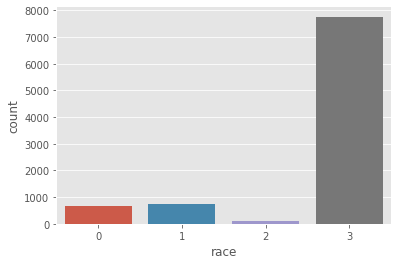

In [711]:
sns.countplot(train['race'])

In [716]:
zero_index = train[train['race']==0].index.values
one_index = train[train['race']==1].index.values
two_index = train[train['race']==2].index.values
three_index = train[train['race']==3].index.values

In [726]:
xzero, yzero = train.loc[zero_index]['text'], train.loc[zero_index]['bin_label']
xone, yone = train.loc[one_index]['text'], train.loc[one_index]['bin_label']
xtwo, ytwo = train.loc[two_index]['text'], train.loc[two_index]['bin_label']
xthree, ythree = train.loc[three_index]['text'], train.loc[three_index]['bin_label']

In [727]:
xzero = tokenizer.texts_to_sequences(xzero)
xzero = keras.preprocessing.sequence.pad_sequences(xzero, maxlen=maxlen)

xone = tokenizer.texts_to_sequences(xone)
xone = keras.preprocessing.sequence.pad_sequences(xone, maxlen=maxlen)

xtwo = tokenizer.texts_to_sequences(xtwo)
xtwo = keras.preprocessing.sequence.pad_sequences(xtwo, maxlen=maxlen)

xthree = tokenizer.texts_to_sequences(xthree)
xthree = keras.preprocessing.sequence.pad_sequences(xthree, maxlen=maxlen)

In [728]:
zero_model = recurrent_cnn2()
one_model = recurrent_cnn2()
two_model = recurrent_cnn2()
three_model = recurrent_cnn2()

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_95 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_31 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_57 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 bidirectional_58 (Bidirecti  (None, None, 128)        74496     
 onal)                                                           
                                                                 
 conv1d_43 (Conv1D)          (None, None, 32)          12320     
                                                     

Epoch 1/40
20/20 [==============================] - 17s 155ms/step - loss: 0.4290 - accuracy: 0.8101 - val_loss: 0.3567 - val_accuracy: 0.8088
Epoch 2/40
20/20 [==============================] - 2s 107ms/step - loss: 0.4192 - accuracy: 0.8314 - val_loss: 0.3421 - val_accuracy: 0.8824
Epoch 3/40
20/20 [==============================] - 3s 134ms/step - loss: 0.4113 - accuracy: 0.8347 - val_loss: 0.3657 - val_accuracy: 0.8088
Epoch 4/40
20/20 [==============================] - 2s 114ms/step - loss: 0.4065 - accuracy: 0.8265 - val_loss: 0.3461 - val_accuracy: 0.8529
Epoch 5/40
20/20 [==============================] - 2s 118ms/step - loss: 0.3978 - accuracy: 0.8396 - val_loss: 0.3438 - val_accuracy: 0.8529
Epoch 6/40
20/20 [==============================] - 2s 113ms/step - loss: 0.3900 - accuracy: 0.8445 - val_loss: 0.3395 - val_accuracy: 0.8676
Epoch 7/40
20/20 [==============================] - 2s 109ms/step - loss: 0.3954 - accuracy: 0.8314 - val_loss: 0.3324 - val_accuracy: 0.8824
Epoch

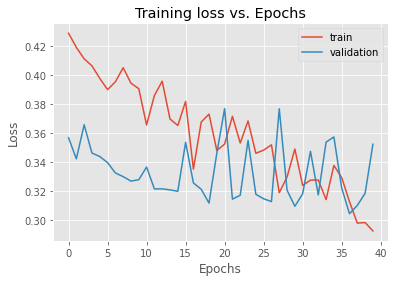

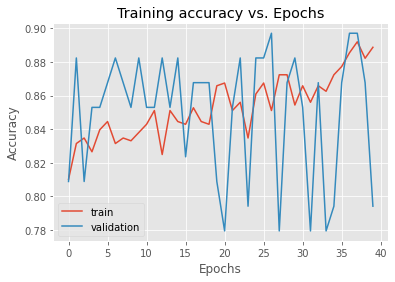

42/42 [==============================] - 1s 35ms/step
Accuracy: 76.36%
F1 Score: 0.827738
Accuracy on mini_dem: 82.73%
F1 Score mini_dem: 0.905481

White FPR: 0.17142857142857143
Hispanic FPR: 0.16716417910447762
AA FPR: 0.28313253012048195
Other FPR: 0.0


In [768]:
run(zero_model, model_name='zero_model', X_train=xzero, y_train=yzero, epochs=40)

Epoch 1/40
22/22 [==============================] - 16s 386ms/step - loss: 0.3863 - accuracy: 0.8465 - val_loss: 0.3320 - val_accuracy: 0.8701
Epoch 2/40
22/22 [==============================] - 4s 165ms/step - loss: 0.3903 - accuracy: 0.8421 - val_loss: 0.3293 - val_accuracy: 0.8961
Epoch 3/40
22/22 [==============================] - 4s 169ms/step - loss: 0.3531 - accuracy: 0.8611 - val_loss: 0.3220 - val_accuracy: 0.8701
Epoch 4/40
22/22 [==============================] - 5s 216ms/step - loss: 0.3677 - accuracy: 0.8494 - val_loss: 0.3272 - val_accuracy: 0.8831
Epoch 5/40
22/22 [==============================] - 5s 220ms/step - loss: 0.3650 - accuracy: 0.8523 - val_loss: 0.3248 - val_accuracy: 0.8701
Epoch 6/40
22/22 [==============================] - 3s 152ms/step - loss: 0.3610 - accuracy: 0.8465 - val_loss: 0.3823 - val_accuracy: 0.8961
Epoch 7/40
22/22 [==============================] - 4s 171ms/step - loss: 0.3382 - accuracy: 0.8523 - val_loss: 0.3339 - val_accuracy: 0.8701
Epoch

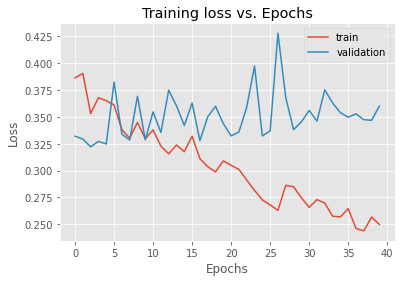

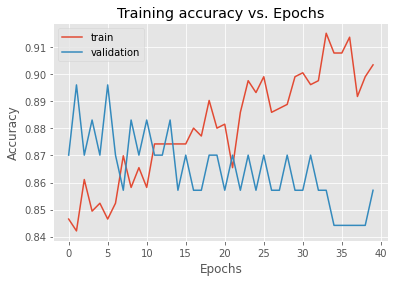

42/42 [==============================] - 1s 27ms/step
Accuracy: 74.85%
F1 Score: 0.810040
Accuracy on mini_dem: 80.93%
F1 Score mini_dem: 0.894628

White FPR: 0.19244391971664698
Hispanic FPR: 0.1761194029850746
AA FPR: 0.2740963855421687
Other FPR: 0.011764705882352941


In [769]:
run(one_model, model_name='one_model', X_train=xone, y_train=yone, epochs=40)

Epoch 1/40
3/3 [==============================] - 5s 736ms/step - loss: 0.4643 - accuracy: 0.8161 - val_loss: 0.5872 - val_accuracy: 0.6000
Epoch 2/40
3/3 [==============================] - 0s 102ms/step - loss: 0.4546 - accuracy: 0.8161 - val_loss: 0.5810 - val_accuracy: 0.6000
Epoch 3/40
3/3 [==============================] - 0s 124ms/step - loss: 0.4294 - accuracy: 0.8276 - val_loss: 0.5796 - val_accuracy: 0.6000
Epoch 4/40
3/3 [==============================] - 0s 120ms/step - loss: 0.4377 - accuracy: 0.8391 - val_loss: 0.5852 - val_accuracy: 0.6000
Epoch 5/40
3/3 [==============================] - 0s 109ms/step - loss: 0.4788 - accuracy: 0.8046 - val_loss: 0.5727 - val_accuracy: 0.8000
Epoch 6/40
3/3 [==============================] - 0s 122ms/step - loss: 0.4215 - accuracy: 0.8161 - val_loss: 0.5691 - val_accuracy: 0.8000
Epoch 7/40
3/3 [==============================] - 0s 112ms/step - loss: 0.4493 - accuracy: 0.8506 - val_loss: 0.5685 - val_accuracy: 0.8000
Epoch 8/40
3/3 [====

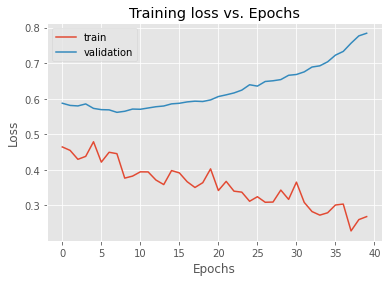

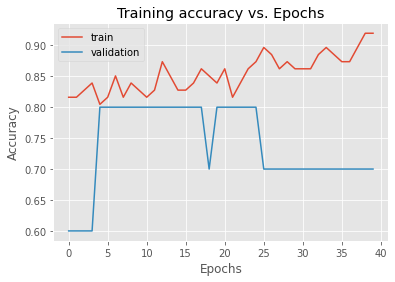

42/42 [==============================] - 1s 26ms/step
Accuracy: 72.89%
F1 Score: 0.787196
Accuracy on mini_dem: 75.99%
F1 Score mini_dem: 0.863545

White FPR: 0.24250295159386068
Hispanic FPR: 0.23880597014925373
AA FPR: 0.32831325301204817
Other FPR: 0.011764705882352941


In [771]:
run(two_model, model_name='two_model', X_train=xtwo, y_train=ytwo, epochs=40)

Epoch 1/40
219/219 [==============================] - 29s 115ms/step - loss: 0.4561 - accuracy: 0.7878 - val_loss: 0.4858 - val_accuracy: 0.7606
Epoch 2/40
219/219 [==============================] - 24s 111ms/step - loss: 0.4495 - accuracy: 0.7935 - val_loss: 0.4848 - val_accuracy: 0.7632
Epoch 3/40
219/219 [==============================] - 24s 110ms/step - loss: 0.4515 - accuracy: 0.7930 - val_loss: 0.4835 - val_accuracy: 0.7542
Epoch 4/40
219/219 [==============================] - 25s 116ms/step - loss: 0.4475 - accuracy: 0.7954 - val_loss: 0.4943 - val_accuracy: 0.7503
Epoch 5/40
219/219 [==============================] - 27s 121ms/step - loss: 0.4414 - accuracy: 0.7980 - val_loss: 0.4968 - val_accuracy: 0.7555
Epoch 6/40
219/219 [==============================] - 24s 111ms/step - loss: 0.4396 - accuracy: 0.8003 - val_loss: 0.4924 - val_accuracy: 0.7568
Epoch 7/40
219/219 [==============================] - 26s 120ms/step - loss: 0.4372 - accuracy: 0.7942 - val_loss: 0.4970 - val_ac

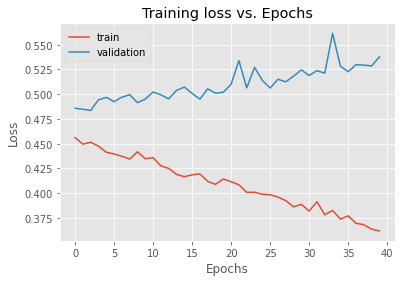

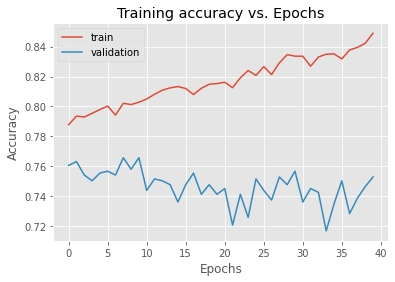

42/42 [==============================] - 1s 27ms/step
Accuracy: 77.42%
F1 Score: 0.838988
Accuracy on mini_dem: 84.33%
F1 Score mini_dem: 0.914964

White FPR: 0.15301062573789848
Hispanic FPR: 0.1701492537313433
AA FPR: 0.2710843373493976
Other FPR: 0.0


In [772]:
run(three_model, model_name='three_model', X_train=xthree, y_train=ythree, epochs=40)

In [773]:
dev_exp = pd.DataFrame()
dev_exp['text'] = dem['text']
dev_exp['label'] = dem['label']
dev_exp['races'] = dem['race']

In [774]:
dev_exp['pred_one'] = one_model.predict(X_test_dev)

In [775]:
dev_exp['pred_two'] = two_model.predict(X_test_dev)

In [776]:
dev_exp['pred_three'] = three_model.predict(X_test_dev)

In [777]:
dev_exp['pred_zero'] = zero_model.predict(X_test_dev)

In [778]:
final_pred = []

for i in range(len(dev_exp['races'].values)):
    pred = 0.0
    r0 = dev_exp['races'].values[i][0] * dev_exp['pred_zero'][i]
    r1 = dev_exp['races'].values[i][1] * dev_exp['pred_one'][i]
    r2 = dev_exp['races'].values[i][2] * dev_exp['pred_two'][i]
    r3 = dev_exp['races'].values[i][3] * dev_exp['pred_three'][i]
    pred = r0 + r1 + r2 + r3
    final_pred.append(pred)

In [779]:
dev_exp['final_pred'] = final_pred

In [780]:
dev_exp['pred_label'] = [0 if x<0.5 else 1 for x in dev_exp.final_pred.values]

In [781]:
dev_exp

,text,label,races,pred_one,pred_two,pred_three,pred_zero,final_pred,pred_label
0,people make mistakes takes good person learn l...,1,"[0.08882822483660359, 0.4140847422065007, 0.00...",0.987072,0.960885,0.987685,0.926010,0.981932,1
1,one road power cable internet guess not,1,"[0.16363711701688377, 0.10807288972832205, 0.0...",0.960131,0.905718,0.989435,0.914744,0.973838,1
2,love baby yawn think cute,1,"[0.16817508635224418, 0.6526162423580347, 0.00...",0.968904,0.941002,0.979436,0.977599,0.972218,1
3,theres many hoes actually think,1,"[0.1236687298458153, 0.5362901511942896, 0.001...",0.949286,0.853931,0.947412,0.975667,0.951804,1
4,today day adalynn alexis not believe number mo...,1,"[0.03992739344782069, 0.6484418266345365, 2.13...",0.996728,0.990508,0.993940,0.990173,0.995597,1
...,...,...,...,...,...,...,...,...,...
5067,favorite seat cambus single one back overlooks...,1,"[0.13983208751915163, 0.18230225544472586, 0.0...",0.936293,0.404144,0.917145,0.792235,0.902693,1
5068,haha,1,"[2.967985607067021e-05, 0.6160165675779754, 0....",0.855137,0.876049,0.970395,0.964916,0.897195,1
5069,straight relaxin right,1,"[0.35348563877276773, 0.3283878201280321, 0.01...",0.311820,0.414909,0.823440,0.765832,0.627497,1
5070,una bala mas aire,1,"[0.003283857176429411, 0.016851569999438192, 0...",0.820670,0.810595,0.883887,0.840459,0.811002,1


In [782]:
mini_demographic_dev["pred_label"] = dev_exp['pred_label']

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("")
print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)


White FPR: 0.15985832349468712
Hispanic FPR: 0.16119402985074627
AA FPR: 0.2891566265060241
Other FPR: 0.0058823529411764705


In [1054]:
og_train = pd.read_csv("civility_data/train.tsv", sep='\t')
og_train[og_train['label'] == 'NOT'].head(50)

,text,label,category
16,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,NaN
17,@USER BREAKING: 9th Circuit Order @USER To Del...,NOT,NaN
19,@USER Peach is naturally human. Toadette just ...,NOT,NaN
20,80% of women use silence to express pain You k...,NOT,NaN
22,@USER @USER @USER @USER What exactly do you me...,NOT,NaN
23,@USER @USER Free milk is a health issue not an...,NOT,NaN
24,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT,NaN
25,@USER Holder is worse than John Gotti or Al Ca...,NOT,NaN
26,@USER She is sooooo pretty!!!!!,NOT,NaN
27,@USER &amp; this statement by Jewish Antifa Be...,NOT,NaN


,text,label,category,len,race,bin_label
1,seems hard believe stood next guy wearing shor...,OFF,TIN,12,3,0
2,wow wonder liberals got worse party bullies wo...,OFF,TIN,9,3,0
3,not idiots grandstands like,OFF,TIN,4,1,0
4,bring hypocrite gungrabber maga,OFF,TIN,4,3,0
6,thing agree match point following rules think ...,OFF,TIN,14,3,0
...,...,...,...,...,...,...
10569,head fuckin egg,OFF,UNT,3,0,0
10575,advocating conduct within bounds human rights ...,OFF,TIN,27,3,0
10579,liars like antifa twins vigorously defend,OFF,TIN,6,3,0
10587,sometimes get strong vibes people man vibe ten...,OFF,TIN,11,3,0


In [959]:
test['processed'] = preprocessing(test.text.values)
test

100%|██████████| 6396/6396 [00:04<00:00, 1283.03it/s]


,text,probs,processed
0,Black Female Democrats Call for Changes in Par...,0.394738,black female democrats call changes party url ...
1,After making fun of myself (and @USER a little...,0.056393,making fun little watching premier number time...
2,You know what I hate? Negros.,0.274090,know hate negros
3,:(( I want him to rest 4ever :((( He is such a...,0.511725,sad want rest ever sad sleepy baby sad url
4,I wish I can blink my eyes and I'll magically ...,0.071799,wish blink eyes magically ready
...,...,...,...
6391,Celtics lose to Bobcats,0.369761,celtics lose bobcats
6392,Does anyone know if things got easier out ther...,0.056760,anyone know things got easier pimps
6393,"Nothing like girl time with junk food, warm su...",0.051441,nothing like girl time junk food warm summer n...
6394,@USER This is a guy who weaponized the judicia...,0.025189,guy weaponized judicial system irs attack cons...


In [964]:
test = test.drop(columns=['probs'])

In [965]:
test

,text,processed
0,Black Female Democrats Call for Changes in Par...,black female democrats call changes party url ...
1,After making fun of myself (and @USER a little...,making fun little watching premier number time...
2,You know what I hate? Negros.,know hate negros
3,:(( I want him to rest 4ever :((( He is such a...,sad want rest ever sad sleepy baby sad url
4,I wish I can blink my eyes and I'll magically ...,wish blink eyes magically ready
...,...,...
6391,Celtics lose to Bobcats,celtics lose bobcats
6392,Does anyone know if things got easier out ther...,anyone know things got easier pimps
6393,"Nothing like girl time with junk food, warm su...",nothing like girl time junk food warm summer n...
6394,@USER This is a guy who weaponized the judicia...,guy weaponized judicial system irs attack cons...


In [969]:
X_test_ = tokenizer.texts_to_sequences(test.processed.values)
X_test_ = sequence.pad_sequences(X_test_, maxlen=maxlen)

In [989]:
best_model = keras.models.load_model('recurrent_cnn1.h5')

In [990]:
predictions = best_model.predict(X_test_, batch_size=len(X_test_))

In [991]:
test['preds'] = predictions

In [992]:
test['label'] = [0 if x<0.5 else 1 for x in test.preds.values]

<AxesSubplot:xlabel='label', ylabel='count'>

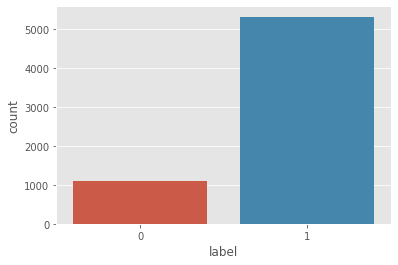

In [993]:
sns.countplot(test['label'])

In [996]:
test['race'] = [x for x in get_race.predict_proba(test.processed.values)]

In [997]:
test

,text,processed,preds,label,race
0,Black Female Democrats Call for Changes in Par...,black female democrats call changes party url ...,0.938978,1,"[0.42769881995168474, 0.0951857220568026, 0.03..."
1,After making fun of myself (and @USER a little...,making fun little watching premier number time...,0.973871,1,"[0.04193307871918143, 0.3766700847711959, 0.00..."
2,You know what I hate? Negros.,know hate negros,0.579832,1,"[0.27409011672698186, 0.483230824784873, 0.014..."
3,:(( I want him to rest 4ever :((( He is such a...,sad want rest ever sad sleepy baby sad url,0.953556,1,"[0.06057618486782467, 0.8295482843543431, 0.00..."
4,I wish I can blink my eyes and I'll magically ...,wish blink eyes magically ready,0.972701,1,"[0.07179912519738596, 0.31815189122079823, 0.0..."
...,...,...,...,...,...
6391,Celtics lose to Bobcats,celtics lose bobcats,0.874355,1,"[0.3697614154320505, 0.12816851551003752, 0.09..."
6392,Does anyone know if things got easier out ther...,anyone know things got easier pimps,0.932005,1,"[0.05675973918926426, 0.3196592044636006, 0.00..."
6393,"Nothing like girl time with junk food, warm su...",nothing like girl time junk food warm summer n...,0.945838,1,"[0.05144109096383211, 0.27895973679623964, 0.0..."
6394,@USER This is a guy who weaponized the judicia...,guy weaponized judicial system irs attack cons...,0.362489,0,"[0.023958406670036323, 0.30438774435137655, 0...."


In [998]:
test['lambda'] = [np.std(x) for x in test['race'].values]

In [1000]:
test['final_preds'] = test['preds'] + test['lambda']

In [1055]:
test['final_label'] = [0 if x<0.55 else 1 for x in test.final_preds.values]

In [1056]:
test[test['final_label'] != test['label']]

,text,processed,preds,label,race,lambda,final_preds,final_label,race_label
25,50 shades of grey is going to be a movie... is...,number shades grey going movie not pretty much...,0.436406,0,"[0.04609110078815983, 0.2529960109461705, 0.00...",0.277070,0.713475,1,3
83,@USER Liberals support conflicting viewpoints ...,liberals support conflicting viewpoints score ...,0.408047,0,"[0.15576193862520116, 0.08514581517292802, 0.0...",0.280110,0.688157,1,3
89,@USER You must be on your 2nd bottle of vodka ...,must bottle vodka gonna say reps radicalized s...,0.422301,0,"[0.023396247426970124, 0.16957640987377684, 0....",0.327284,0.749585,1,3
96,I hope you fall inside a hole and die :) &lt;3,hope fall inside hole die happy number,0.473494,0,"[0.029253999407764353, 0.3652844286615976, 0.0...",0.246155,0.719649,1,3
123,@USER @USER there's fish poop in your shower???,fish poop shower,0.371424,0,"[0.07763476383142223, 0.2647302445371472, 0.01...",0.242451,0.613876,1,3
...,...,...,...,...,...,...,...,...,...
6359,@USER alright but if I mess them up don't blam...,alright mess not blame,0.441524,0,"[0.15191549849491892, 0.4762298588128754, 0.00...",0.185470,0.626994,1,1
6363,Last night I dreamed Channing Tatum and I lock...,last night dreamed channing tatum locked book ...,0.479878,0,"[0.03902040513708751, 0.3705596881689254, 0.00...",0.238206,0.718083,1,3
6365,@USER remember when I pissed on Tim lol,remember pissed tim lol,0.436500,0,"[0.25907449381466385, 0.1498018472895261, 0.00...",0.216253,0.652752,1,3
6368,Lol I find if funny when boys try to be sneaky...,lol find funny boys try sneaky like girls not ...,0.396696,0,"[0.11596650395387102, 0.28660598403956133, 5.1...",0.225006,0.621702,1,3


<AxesSubplot:xlabel='final_label', ylabel='count'>

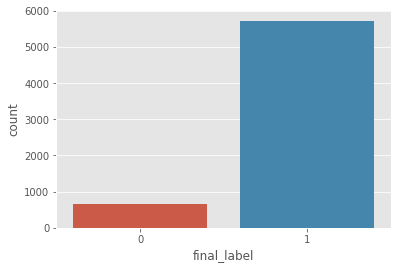

In [1057]:
sns.countplot(test['final_label'])

In [1066]:
labels = pd.DataFrame()
labels['label'] = test.final_label.values

In [1068]:
labels.to_csv(path_or_buf='Athiya_Deviyani_advanced.tsv', sep='\t', index=False)

In [1048]:
test['race_label'] = get_race.predict(test.processed.values)

In [1049]:
test[test['race_label'] == 0][test['final_label'] != test['label']].head(20)

,text,processed,preds,label,race,lambda,final_preds,final_label,race_label
280,Her mouth is like my house so I guess you can ...,mouth like house guess say coming home,0.460055,0,"[0.40752639105851385, 0.2415735093311957, 9.29...",0.156173,0.616228,1,0
307,@USER @USER FASCISTS OF THE FUTURE WILL CALL T...,fascists future call anti fascist antifa comes...,0.407138,0,"[0.5421910384273476, 0.21589052055368327, 0.01...",0.188103,0.595241,1,0
383,Yo gucci twitter back up. Nigga gotta be hacked.,gucci twitter back nigga gotta hacked,0.255745,0,"[0.8791090415144363, 0.11398288998486543, 0.00...",0.366015,0.621760,1,0
432,I look like a bum,look like bum,0.425392,0,"[0.4404211037372505, 0.23625905737737002, 0.00...",0.160386,0.585778,1,0
480,@USER Hell NO,hell,0.364189,0,"[0.5703833461841752, 0.08670140768325449, 0.01...",0.218715,0.582904,1,0
530,@USER @USER @USER If he is from AZ I would put...,would put money sex underage kids,0.472524,0,"[0.4331525108567298, 0.13497199234006638, 0.00...",0.186807,0.659331,1,0
813,Mondays...I be so like blah,mondays like blah,0.478028,0,"[0.3956483758585281, 0.388659910702724, 0.0066...",0.159173,0.637201,1,0
957,Ion trust no nigga. Not even da ones who round...,ion trust nigga not even ones round,0.313452,0,"[0.9827448833305997, 0.015307553578573269, 4.4...",0.423091,0.736543,1,0
1036,@USER you know you always got me my nigga !,know always got nigga,0.430215,0,"[0.7025264577546153, 0.29457155830520565, 2.78...",0.287369,0.717584,1,0
1143,@USER SMH,smh,0.370121,0,"[0.9450928620563853, 0.045108207253537834, 0.0...",0.401649,0.771770,1,0


## Model 16: Recurrent CNN3

In [369]:
def recurrent_cnn3():
    embedded = keras.layers.Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)

    model = keras.Sequential([
        embedded,
        keras.layers.SpatialDropout1D(0.3),
        keras.layers.Bidirectional(keras.layers.GRU(64,return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),
        keras.layers.Convolution1D(32, 3, activation="relu"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(25, activation="relu"),
        keras.layers.Dropout(0.40),
        keras.layers.Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
            loss=tf.losses.BinaryCrossentropy(from_logits=True),
            metrics=['accuracy'])

    print(model.summary())
    
    return model

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_91 (Embedding)    (None, None, 100)         1609700   
                                                                 
 spatial_dropout1d_28 (Spati  (None, None, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_53 (Bidirecti  (None, None, 128)        63744     
 onal)                                                           
                                                                 
 bidirectional_54 (Bidirecti  (None, None, 128)        98816     
 onal)                                                           
                                                                 
 conv1d_40 (Conv1D)          (None, None, 32)          12320     
                                                     

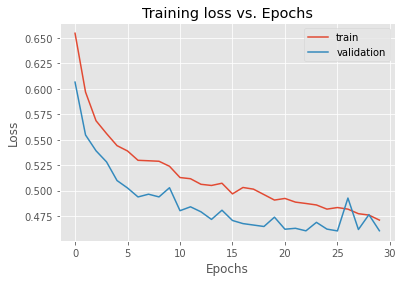

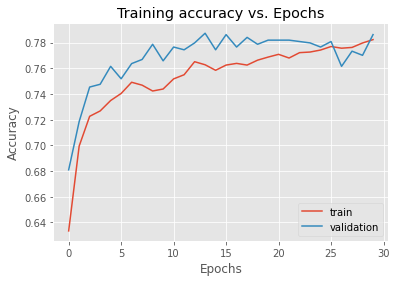

42/42 [==============================] - 3s 29ms/step
Accuracy: 78.47%
F1 Score: 0.849286
Accuracy on mini_dem: 85.07%
F1 Score mini_dem: 0.919357

White FPR: 0.14451003541912633
Hispanic FPR: 0.1701492537313433
AA FPR: 0.26506024096385544
Other FPR: 0.0


In [370]:
run(recurrent_cnn3(), 'recurrent_cnn3', epochs=30)

## Model 17: Transformer

In [11]:
## RESET
dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

X_train = train["text"].values
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])
X_test_dev = mini_demographic_dev["text"].values
y_test_dev = mini_demographic_dev["bin_label"].values

# Clean text
def preprocessing(data):
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in data:
        review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
        review = re.sub('RT', ' ', review)
        review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
        review = re.sub(r"https?", " ", review)
        review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)

    return np.array(corpus)

print("Preprocessing tweets...")
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)
X_test_dev = preprocessing(X_test_dev)


"""
## Setup
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


"""
## Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


"""
## Download and prepare dataset
"""

vocab_size = 16097
maxlen = 260

# vocab_size = 20000  # Only consider the top 20k words
# maxlen = 200  # Only consider the first 200 words of each movie review
# (x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
# print(len(x_train), "Training sequences")
# print(len(x_val), "Validation sequences")
# x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
# x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_test_dev = tokenizer.texts_to_sequences(X_test_dev)
x_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
x_test_dev = keras.preprocessing.sequence.pad_sequences(X_test_dev, maxlen=maxlen)

"""
## Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.
"""


embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


"""
## Train and Evaluate
"""

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train, y_train, batch_size=32, epochs=3, validation_split=0.1
)

Preprocessing tweets...
Epoch 1/3
298/298 [==============================] - 45s 147ms/step - loss: 0.6448 - accuracy: 0.6650 - val_loss: 0.6441 - val_accuracy: 0.6547
Epoch 2/3
298/298 [==============================] - 53s 178ms/step - loss: 0.5809 - accuracy: 0.7079 - val_loss: 0.5397 - val_accuracy: 0.7415
Epoch 3/3
298/298 [==============================] - 58s 193ms/step - loss: 0.4063 - accuracy: 0.8208 - val_loss: 0.5378 - val_accuracy: 0.7302


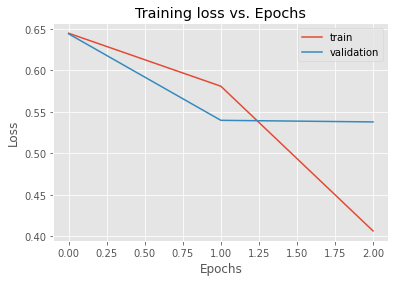

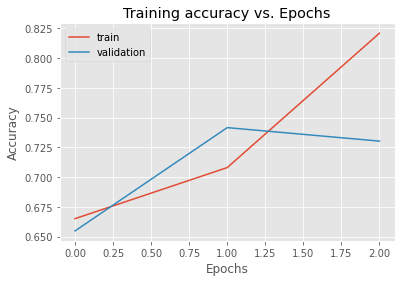

42/42 [==============================] - 3s 62ms/step
Accuracy: 28.25%
F1 Score: 0.312590


In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.savefig('transformer_loss.png')
plt.show()
plt.close()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.savefig('transformer_accuracy.png')
plt.show()
plt.close()


y_pred = model.predict(x_test, verbose=1, batch_size=32)
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

print("================================================")

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

In [172]:
len(X_train)

10592